## Imports

In [15]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## AudioFile class

- `file_path`: Path to the audio file
- `file_name`: Name of the audio file (extracted from the path)
- `label`: Label of the audio file (derived from the parent directory name)
- `audio`: Loaded audio data
- `sample_rate`: Sampling rate of the audio file
- `duration`: Duration of the audio file in seconds

### Methods

- `display_waveform()`: Display the waveform of the audio file
- `play()`: Play the audio file and return an audio player widget
- `trim(top_db=30)`: Trim silent parts of the audio using a decibel threshold
- `create_spectrogram()`: Generate a mel spectrogram of the audio file
- `show_spectrogram()`: Display the spectrogram of the audio file
- `save_spectrogram(output_dir=None, skip_existing=True)`: Save the spectrogram as a PNG file


In [3]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


# Data Pipeline

In [4]:
# Define paths
data_folder='data/audio/Speech Commands'
pd.DataFrame(os.listdir(data_folder),columns=['Files'])

,Files
0,backward
1,bed
2,bird
3,cat
4,dog
5,down
6,eight
7,five
8,follow
9,forward


## Create time series dataset

In [5]:
def create_dataset(path):
    """
    Loop through a folder in the given "path" and loads audio time series data into a list.
    Fetches labels for each subfolder and returns them in along with each file path, sample rate, and duration.
    """
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for fil in os.listdir(folder_path):
            file_path = os.path.join(folder_path,fil)
            audio_file = AudioFile(file_path)
            audio_data = audio_file.audio
            sample_rate = audio_file.sample_rate
            duration = audio_file.duration
            file_paths.append(file_path)
            data.append(audio_data)
            sample.append(sample_rate)
            label.append(folder)
            durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)

# Create a dataframe to store all of our data
audio_df = pd.DataFrame()

# Create each respective column and import data
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths, label, sample, durations
audio_df

,file_paths,Label,sample,duration
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0


## Create numbered labels

In [6]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


## Add numbered labels column

In [7]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
...,...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34


## Pad the audio data, so each file is the same duration

In [8]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

## Split padded data into train/val/test for baseline model testing

In [9]:
from sklearn.model_selection import train_test_split

# Split indices for train, test, and validation sets
train_idx, test_idx = train_test_split(
    audio_df.index,  # Use DataFrame indices
    test_size=0.2,  # 20% for test
    stratify=audio_df['Numbered Label'],  # Stratify based on the numeric labels
    random_state=42
)

train_idx, val_idx = train_test_split(
    train_idx,  # Split the remaining data
    test_size=0.25,  # 25% of the remaining 80% -> 20% total for validation
    stratify=audio_df.loc[train_idx, 'Numbered Label'],  # Stratify on the training subset
    random_state=42
)

# Convert indices into sets
train_audio = [audio_data_padded[i] for i in train_idx]
val_audio = [audio_data_padded[i] for i in val_idx]
test_audio = [audio_data_padded[i] for i in test_idx]

train_labels = audio_df.loc[train_idx, 'Numbered Label'].values
val_labels = audio_df.loc[val_idx, 'Numbered Label'].values
test_labels = audio_df.loc[test_idx, 'Numbered Label'].values

## Extract MFCC's features for baseline models

In [10]:
def extract_mfcc(audio_data, sr=22050, n_mfcc=13):
    features = []
    for data in audio_data:
        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)  # Shape: (13, n_frames)

        # Flatten MFCCs to (13 * n_frames,)
        features.append(mfcc.flatten())
    return np.array(features)

# Extract MFCCs
train_mfcc_features = extract_mfcc(train_audio)  # List of (13, n_frames)
val_mfcc_features = extract_mfcc(val_audio)  # List of (13, n_frames)
test_mfcc_features = extract_mfcc(test_audio)  # List of (13, n_frames)

## Random Forest Model

Use Grid Search to find optimal parameters

In [11]:
param_grid = {
    'n_estimators': [5, 50, 100, 200, 300, 400, 500],
    'max_depth': [None, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt',]
}

# Perform Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_mfcc_features, train_labels)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the model with best params
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


In [12]:
# Convert Grid Search results to a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display relevant columns
cv_results = cv_results[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Sort by best rank (lowest rank = best model)
cv_results = cv_results.sort_values(by="rank_test_score")

# Show the top 10 results
cv_results.head(10)

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
6,500,None,2,0.664630,0.002175,1
5,400,None,2,0.661118,0.003577,2
4,300,None,2,0.655763,0.003060,3
3,200,None,2,0.647810,0.001573,4
2,100,None,2,0.624722,0.001372,5
1,50,None,2,0.585351,0.002363,6
0,5,None,2,0.324693,0.001774,7
11,300,5,2,0.285651,0.003567,8
13,500,5,2,0.285572,0.002839,9
12,400,5,2,0.284754,0.003732,10


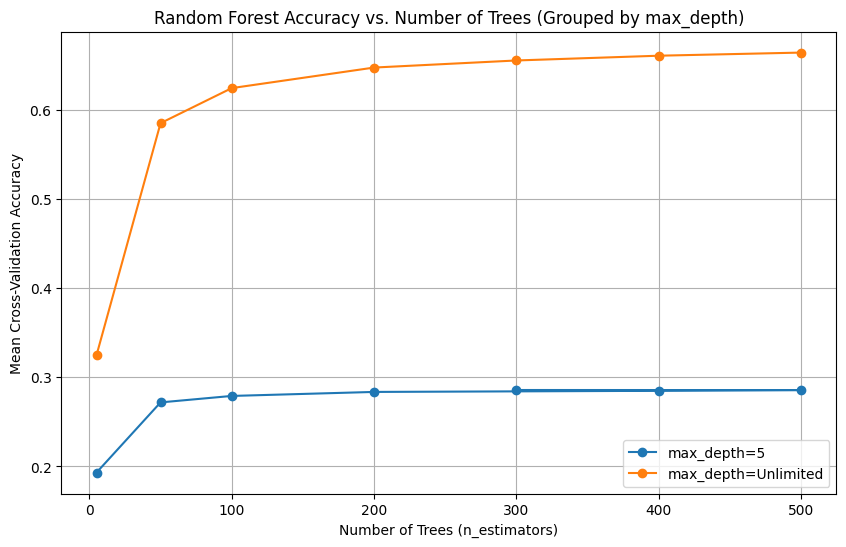

In [13]:
import seaborn as sns

plt.figure(figsize=(10,6))

# Convert None values to string "Unlimited" for visualization
cv_results["param_max_depth"] = cv_results["param_max_depth"].apply(lambda x: "Unlimited" if x is None else x)

# Loop through different values of max_depth
for depth in sorted(cv_results["param_max_depth"].unique(), key=lambda x: float('inf') if x == "Unlimited" else int(x)):
    subset = cv_results[cv_results["param_max_depth"] == depth]
    plt.plot(subset["param_n_estimators"].astype(int), subset["mean_test_score"], marker='o', label=f"max_depth={depth}")

# Labels and title
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("Random Forest Accuracy vs. Number of Trees (Grouped by max_depth)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

## K Nearest Neighbors

Use Grid Search to find optimal parameters

In [16]:
# Finding the optimal number of neighbors
param_grid = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]} 
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_mfcc_features, train_labels)

# Print the best parameter and best cross-validated score.
print("Best number of neighbors:", grid_search.best_params_['n_neighbors'])
print("Best cross-validation accuracy:", grid_search.best_score_)

Best number of neighbors: 25
Best cross-validation accuracy: 0.5325134448555376


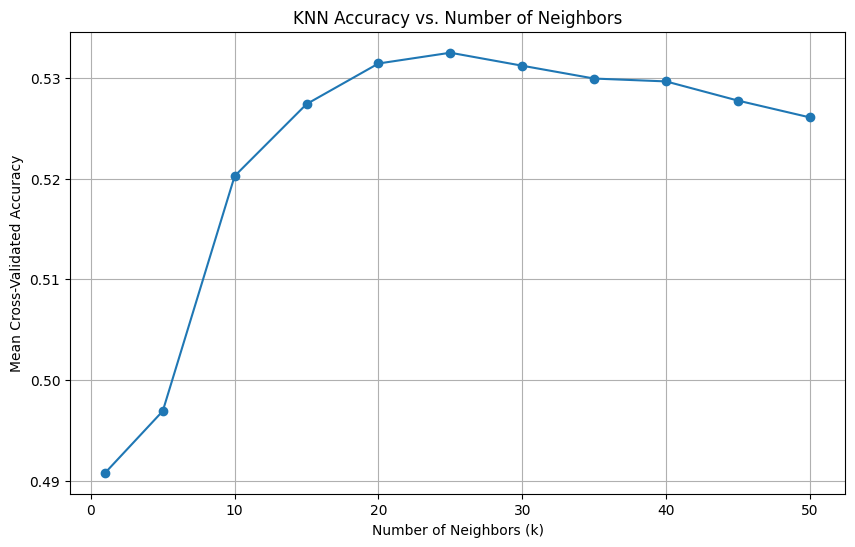

In [17]:
# Plotting how accuracy changes with different number of neighbors
mean_test_scores = grid_search.cv_results_['mean_test_score']
neighbor_values = param_grid['n_neighbors']

# Plot the figure
plt.figure(figsize=(10, 6))
plt.plot(neighbor_values, mean_test_scores, marker='o', linestyle='-')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')
plt.grid(True)
plt.show()

In [20]:
# Testing best number of neighbors on test set
y_pred = grid_search.predict(test_mfcc_features)
test_accuracy = accuracy_score(test_labels, y_pred)
print("Test accuracy:", test_accuracy)

Test accuracy: 0.5510724747236133


In [21]:
from sklearn.decomposition import PCA
from collections import Counter
# Training KNN classifier with 30 neighbors and visualizing nearest neighbor distances

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(train_mfcc_features, train_labels)

index = 100
sample = train_mfcc_features[index].reshape(1, -1)
label = train_labels[index]
predicted_label = knn.predict(sample)[0]

num_neighbors = 30

# Get the distances and indices of the top 50 nearest neighbors
distances, indices = knn.kneighbors(sample, n_neighbors=num_neighbors, return_distance=True)

# Extract the labels of the nearest neighbors.
neighbor_labels = [train_labels[idx] for idx in indices[0]]

# Count the occurrence of each label among the neighbors.
label_counter = Counter(neighbor_labels)
total_neighbors = len(neighbor_labels)

# Printing true label and predicted label
print(f"Sample true label: {label}")
print(f"Sample predicted label: {predicted_label}\n")
print(f"Top {num_neighbors} nearest neighbors for the query sample:")

# Printing neighbors and distances
for rank, (idx, distance) in enumerate(zip(indices[0], distances[0]), start=1):
    neighbor_label = train_labels[idx]
    print(f"Rank {rank}: Label = {neighbor_label}, Distance = {distance:.4f}")

# Print out the neighbor distribution.
print("Neighbor label distribution:")
for label, count in label_counter.items():
    percentage = (count / total_neighbors) * 100
    print(f"  {label}: {count}/{total_neighbors} ({percentage:.1f}%)")

Sample true label: 29
Sample predicted label: 21

Top 30 nearest neighbors for the query sample:
Rank 1: Label = 29, Distance = 0.0000
Rank 2: Label = 34, Distance = 292.7374
Rank 3: Label = 18, Distance = 337.6111
Rank 4: Label = 29, Distance = 345.4305
Rank 5: Label = 34, Distance = 358.9972
Rank 6: Label = 29, Distance = 359.6091
Rank 7: Label = 34, Distance = 375.9199
Rank 8: Label = 6, Distance = 393.8665
Rank 9: Label = 21, Distance = 410.6389
Rank 10: Label = 17, Distance = 412.6915
Rank 11: Label = 27, Distance = 413.9230
Rank 12: Label = 18, Distance = 424.9375
Rank 13: Label = 18, Distance = 441.2704
Rank 14: Label = 27, Distance = 442.7269
Rank 15: Label = 21, Distance = 451.4095
Rank 16: Label = 22, Distance = 474.3691
Rank 17: Label = 14, Distance = 480.0991
Rank 18: Label = 10, Distance = 484.2863
Rank 19: Label = 11, Distance = 489.0921
Rank 20: Label = 3, Distance = 489.9839
Rank 21: Label = 21, Distance = 493.7505
Rank 22: Label = 23, Distance = 505.4106
Rank 23: Label

The word 'go' was predicted correctly, but interesting that the word "no" had the same number of neighbors in the thirty closest neighbors as the correct label "go". In fact, the closest neighbor was the word "no" instead of the correct word "go". This makes sense as they both rhyme and might have very similar MFCCs. 

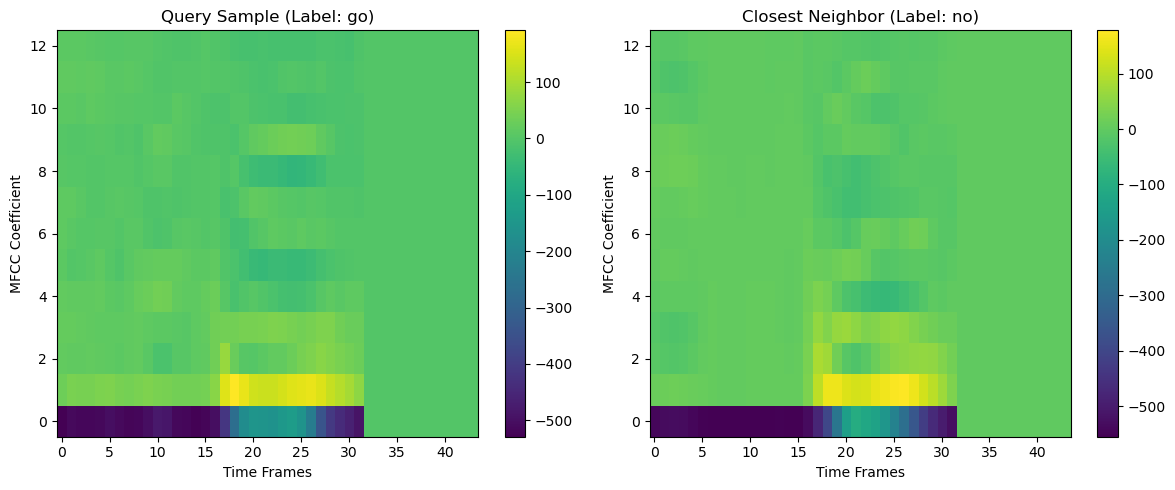

In [ ]:
# Reshape the query sample's MFCC back to its 2D form.
query_mfcc = X_train[index].reshape(n_mfcc, max_pad_len)

# Select the second closest neighbor (index 1 in the sorted list).
second_neighbor_index = indices[0][1]
neighbor_mfcc = X_train[second_neighbor_index].reshape(n_mfcc, max_pad_len)

# Plot the MFCCs side by side for comparison.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot query sample MFCC.
im1 = axs[0].imshow(query_mfcc, aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title(f"Query Sample (Label: {y_train[index]})")
axs[0].set_xlabel("Time Frames")
axs[0].set_ylabel("MFCC Coefficient")
fig.colorbar(im1, ax=axs[0])

# Plot second closest neighbor MFCC.
im2 = axs[1].imshow(neighbor_mfcc, aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title(f"Closest Neighbor (Label: {y_train[second_neighbor_index]})")
axs[1].set_xlabel("Time Frames")
axs[1].set_ylabel("MFCC Coefficient")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()

We can see that the MFCCs are very similar for this recording of the word 'go' and the word 'no'.